(parallel-magics)=

# Parallel Magics

IPython has a few magics to make working with your engines
a bit nicer in IPython, e.g. in a Jupyter notebook.

These are mainly shortcuts to {meth}`.DirectView.execute`
and {meth}`.AsyncResult.display_outputs` methods, respectively.

As always, first we start a cluster (or connect to an existing one):

In [1]:
import ipyparallel as ipp

rc = ipp.Cluster(n=4).start_and_connect_sync()
dv = rc[:]
rc.ids

Starting 4 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

[0, 1, 2, 3]

Creating a Client registers the parallel magics `%px`, `%%px`, `%pxresult`, `%pxconfig`, and `%autopx`.  
These magics are initially associated with a DirectView that is blocking (`block=True`), always associated with all currently registered engines (`targets='all'`),
i.e. adding/removing engines will change where this view's tasks will run.

## The magics

### `%px`

`px` stands for "parallel execute", and is available as both a line magic and cell magic.

The %px magic executes a single Python command on the engines
specified by the `targets` attribute of the {class}`DirectView` instance.
The code entered here does _not_ execute in the local notebook's kernel.

For very small operations, we can execute single lines remotely with the line magic `%px`:

In [2]:
%px a=5

In [3]:
%px print(a)

[stdout:1] 5


[stdout:2] 5


[stdout:0] 5


[stdout:3] 5


In [4]:
%px a

Out[0:3]: 5

Out[1:3]: 5

Out[2:3]: 5

Out[3:3]: 5

In [5]:
%px print("hi")

[stdout:0] hi


[stdout:1] hi


[stdout:2] hi


[stdout:3] hi


### %%px cell magic

The _main_ magic for use in a notebook is the `%%px` cell magic.

`%%px` does the same thing as `%px`, but applies to the whole cell.

In [6]:
%%px
import sys

print("ERROR", file=sys.stderr)

[stderr:0] ERROR


[stderr:1] ERROR


[stderr:2] ERROR


[stderr:3] ERROR


Being a cell magic also frees up the line for options to configure the execution.

To see available options, run `%%px?` (just like all magics):

In [7]:
%%px?

Docstring:
::

  %cell_px [--signal-on-interrupt SIGNAL_ON_INTERRUPT]
               [--progress-after PROGRESS_AFTER_SECONDS] [--no-verbose]
               [--verbose] [-t TARGETS] [--no-stream] [--stream] [-a] [-b]
               [-o SAVE_NAME] [--group-outputs {engine,order,type}] [-e] [-r]
               [--local]

Executes the cell in parallel.

Examples
--------
::

    In [24]: %%px --noblock
       ....: a = os.getpid()
    Async parallel execution on engine(s): all

    In [25]: %%px
       ....: print a
    [stdout:0] 1234
    [stdout:1] 1235
    [stdout:2] 1236
    [stdout:3] 1237

options:
  --signal-on-interrupt SIGNAL_ON_INTERRUPT
                        Send signal to engines on Keyboard Interrupt. By
                        default a SIGINT is sent. Note that this is only
                        applicable when running in blocking mode. Choices:
                        SIGINT, 2, SIGKILL, 9, 0 (nop), etc.
  --progress-after PROGRESS_AFTER_SECONDS
                       

#### Targets

You can specify where you want the code to run with the `--targets` argument.
This lets you quickly set up different combinations of engines as appropriate.
`--targets accepts slice syntax, so you can specify start, stop, and strides,
just like you would slicing a list:

In [8]:
%%px --targets ::2
print("I am even")

[stdout:0] I am even


[stdout:2] I am even


In [9]:
%%px --targets 1
print("I am number 1")

[stdout:1] I am number 1


In [10]:
%%px
print("still 'all' by default")

[stdout:0] still 'all' by default


[stdout:1] still 'all' by default


[stdout:2] still 'all' by default


[stdout:3] still 'all' by default


When setting up your working environment, you might want to do some imports and define some functions _everywhere_, both on engines and here in your local notebook kernel.
That's what `--local` is for:

In [11]:
%%px --local
import os
import socket

import psutil

pid = os.getpid()
p = psutil.Process()


def report_info():
    return {
        "hostname": socket.gethostname(),
        "pid": os.getpid(),
        "memory": p.memory_info().rss,
        "cpu": sum(p.cpu_times()),
    }

In [12]:
report_info()

{'hostname': 'heavy-2.local',
 'pid': 25688,
 'memory': 82870272,
 'cpu': 0.828767104}

In [13]:
%px report_info()

Out[0:9]: 
{'hostname': 'heavy-2.local',
 'pid': 25705,
 'memory': 78331904,
 'cpu': 0.500559408}

Out[1:9]: 
{'hostname': 'heavy-2.local',
 'pid': 25706,
 'memory': 78675968,
 'cpu': 0.50026576}

Out[2:9]: 
{'hostname': 'heavy-2.local',
 'pid': 25707,
 'memory': 78020608,
 'cpu': 0.501814376}

Out[3:8]: 
{'hostname': 'heavy-2.local',
 'pid': 25711,
 'memory': 78954496,
 'cpu': 0.489563088}

#### Blocking (or not)

You don't have to wait for results for every execution.
`%%px --noblock` allows cells to return immediately, without waiting for the result:

In [14]:
%%time
%%px --noblock
import time
time.sleep(2)
pid, time.time()

CPU times: user 3.11 ms, sys: 2.61 ms, total: 5.72 ms
Wall time: 6.25 ms


<AsyncResult(%px): pending>

But you will notice that this didn't output the result of the last command.
For this, we have `%pxresult`, which waits for and displays the output of the latest request:

In [15]:
%time %pxresult

Out[0:10]: (25705, 1730717941.915563)

Out[1:10]: (25706, 1730717941.915562)

Out[2:10]: (25707, 1730717941.918869)

Out[3:9]: (25711, 1730717941.9218612)

CPU times: user 13.5 ms, sys: 5.04 ms, total: 18.5 ms
Wall time: 754 ms


### Configuring defaults with `%pxconfig`

The `%pxconfig` magic lets you configure the _default_ behavior of the `%px` magics.
`%pxconfig` takes the same arguments as `%%px`, but saves them as the default for future calls to `%px` or `%%px`.

In a notebook, I would generally suggest using `%pxconfig` at most once to set up your environment,
and use `%%px --options` for cells that have different behavior than the default.

It is much easier to see what code does and there is less of the dreaded "hidden notebook state."

`%pxconfig` and other line magics are principally for line-based environments like terminal IPython,
where cell magics are impractical.

For example, setting the default targets with `%pxconfig`:

In [16]:
%pxconfig --targets 1
%px print("just 1")

[stdout:1] just 1


In [17]:
%pxconfig --targets 1,2
%px print("1 and 2")

[stdout:1] 1 and 2


[stdout:2] 1 and 2


In [18]:
%pxconfig --targets all
%px print("back to all")

[stdout:0] back to all


[stdout:1] back to all


[stdout:2] back to all


[stdout:3] back to all


#### Remote parallel magics

Remember, an IPython engine is IPython, so you can do magics remotely and in parallel as well!

In [19]:
%px %whos

[stdout:0] Variable      Type        Data/Info
-----------------------------------
p             Process     psutil.Process(pid=25705,<...>ing', started='11:58:29')
pid           int         25705
psutil        module      <module 'psutil' from '/U<...>ages/psutil/__init__.py'>
report_info   function    <function report_info at 0x1071de980>
socket        module      <module 'socket' from '/U<...>ib/python3.11/socket.py'>


[stdout:1] Variable      Type        Data/Info
-----------------------------------
p             Process     psutil.Process(pid=25706,<...>ing', started='11:58:29')
pid           int         25706
psutil        module      <module 'psutil' from '/U<...>ages/psutil/__init__.py'>
report_info   function    <function report_info at 0x1068de840>
socket        module      <module 'socket' from '/U<...>ib/python3.11/socket.py'>


[stdout:2] Variable      Type        Data/Info
-----------------------------------
p             Process     psutil.Process(pid=25707,<...>ing', started='11:58:29')
pid           int         25707
psutil        module      <module 'psutil' from '/U<...>ages/psutil/__init__.py'>
report_info   function    <function report_info at 0x107db6660>
socket        module      <module 'socket' from '/U<...>ib/python3.11/socket.py'>


[stdout:3] Variable      Type        Data/Info
-----------------------------------
p             Process     psutil.Process(pid=25711,<...>ing', started='11:58:29')
pid           int         25711
psutil        module      <module 'psutil' from '/U<...>ages/psutil/__init__.py'>
report_info   function    <function report_info at 0x10afdee80>
socket        module      <module 'socket' from '/U<...>ib/python3.11/socket.py'>


### Output

IPython Parallel understands the Jupyter display protocol.
When setting up a cluster, it is common for engines to want to know their own id or 'rank' in MPI parlance).

You can do this with `scatter` and `flatten=True`:

In [20]:
dv = rc[:]
dv.scatter('rank', dv.targets, flatten=True)
dv['stride'] = len(dv)

In [21]:
%px print(rank, stride)

[stdout:0] 0 4


[stdout:1] 1 4


[stdout:2] 2 4


[stdout:3] 3 4


[stdout:0] 0
4
8


[stdout:2] 2
6
10


[stdout:1] 1
5
9


[stdout:3] 3
7
11


Out[1:16]: Text(0.5, 1.0, 'Plot 1')

Out[3:13]: Text(0.5, 1.0, 'Plot 3')

Out[2:15]: Text(0.5, 1.0, 'Plot 2')

Out[0:14]: Text(0.5, 1.0, 'Plot 0')

[output:0]

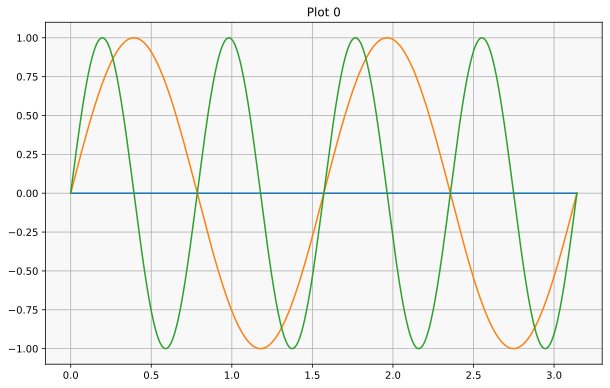

[output:2]

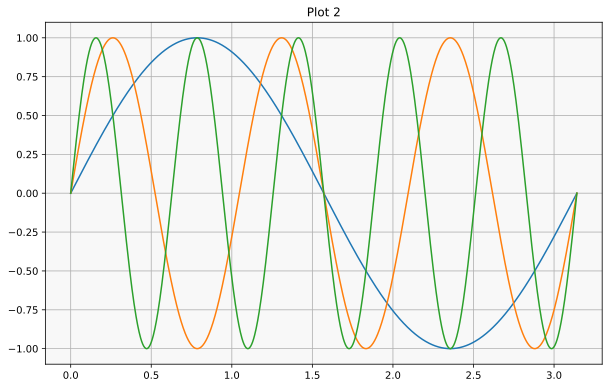

[output:1]

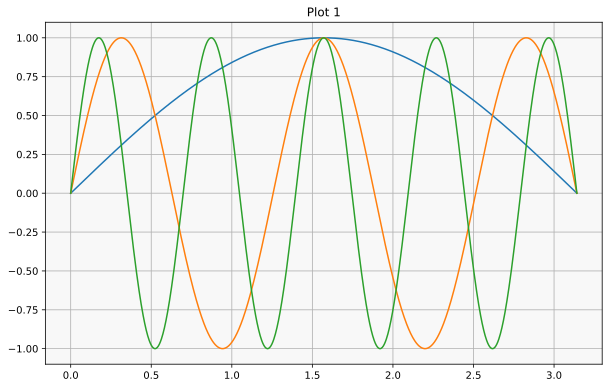

[output:3]

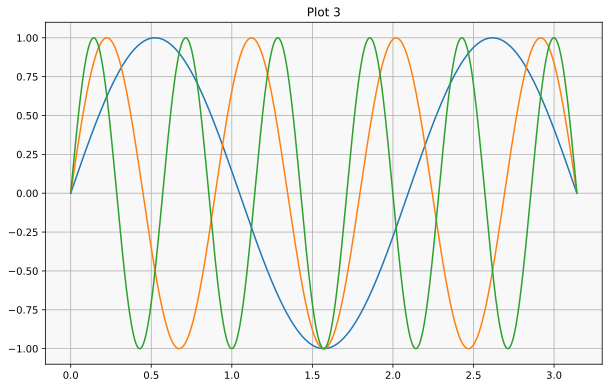

In [22]:
%%px
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, np.pi, 1000)
for n in range(rank, 12, stride):  # noqa
    print(n)
    plt.plot(x, np.sin(n * x))
plt.title(f"Plot {rank}")  # noqa

In [23]:
%%px --noblock
import os
import sys

from IPython.display import HTML, Math, display


def generate_output():
    """function for testing output

    publishes two outputs of each type, and returns something
    """

    print("stdout")
    print("stderr", file=sys.stderr)

    display(HTML("<b>HTML</b>"))

    print("stdout2")
    print("stderr2", file=sys.stderr)

    display(Math(r"\alpha=\beta"))

    return os.getpid()


generate_output()

<AsyncResult(%px): pending>

When we retrieve the result, we can see the outputs

In [24]:
%pxresult

[stdout:0] 
stdout
stdout2
[stdout:1] 
stdout
stdout2
[stdout:2] 
stdout
stdout2
[stdout:3] 
stdout
stdout2


[stderr:0] 
stderr
stderr2
[stderr:1] 
stderr
stderr2
[stderr:2] 
stderr
stderr2
[stderr:3] 
stderr
stderr2


[output:0]

<IPython.core.display.Math object>

[output:1]

<IPython.core.display.Math object>

[output:2]

<IPython.core.display.Math object>

[output:3]

<IPython.core.display.Math object>

Out[0:15]: 25705

Out[1:17]: 25706

Out[2:16]: 25707

Out[3:14]: 25711

`%%px` also lets you choose some amount of the grouping of the outputs with `--group-outputs`:

The choices are:

* `type` - where stdout of each engine is displayed, then stderr, then rich output, etc. (the default)
* `engine` - all of an engine's output is collected together
* `order` - same as `type`, but individual displaypub outputs are interleaved.
  That is, it will output the first plot from each engine, then the second from each,
  etc.

```{seealso}
{meth}`.AsyncResult.display_outputs` for the grouping options.
```


In [25]:
%%px --group-outputs=engine

generate_output()

[stdout:0] stdout
stdout2


[stderr:0] stderr
stderr2


[stdout:2] stdout
stdout2


[stdout:1] stdout
stdout2


[output:0]

[stderr:2] stderr
stderr2


[stderr:1] stderr
stderr2


[output:2]

[output:1]

[stdout:3] stdout
stdout2


[stderr:3] stderr
stderr2


[output:0]

<IPython.core.display.Math object>

[output:3]

Out[0:16]: 25705

[output:2]

<IPython.core.display.Math object>

[output:1]

<IPython.core.display.Math object>

Out[2:17]: 25707

Out[1:18]: 25706

[output:3]

<IPython.core.display.Math object>

Out[3:15]: 25711

When you specify 'order', then individual display outputs (e.g. plots) will be interleaved.


`%pxresult` calls {meth}`.AsyncResult.display_outputs` on the most recent request.
It accepts the same output-grouping arguments as %%px, so you can use it to view
a result in different ways:

In [26]:
%pxresult --group-outputs=order

[stdout:0] 
stdout
stdout2
[stdout:1] 
stdout
stdout2
[stdout:2] 
stdout
stdout2
[stdout:3] 
stdout
stdout2


[stderr:0] 
stderr
stderr2
[stderr:1] 
stderr
stderr2
[stderr:2] 
stderr
stderr2
[stderr:3] 
stderr
stderr2


[output:0]

[output:1]

[output:2]

[output:3]

[output:0]

<IPython.core.display.Math object>

[output:1]

<IPython.core.display.Math object>

[output:2]

<IPython.core.display.Math object>

[output:3]

<IPython.core.display.Math object>

Out[0:16]: 25705

Out[1:18]: 25706

Out[2:17]: 25707

Out[3:15]: 25711

## Magics for multiple views

All of the parallel magics are associated with a particular {class}`~.DirectView` object.
You can change the active view by calling the {meth}`~.DirectView.activate` method
on any view.

In [27]:
even = rc[::2]
even.activate()
%px print("hi")

<AsyncResult(%px): pending>

In [28]:
even.block = True
%px print("hi")

[stdout:2] hi


[stdout:0] hi


When activating a View, you can also specify a _suffix_, so that a whole different
set of magics are associated with that view, without replacing the existing ones.
This way, you can also have more than one set of parallel magics registered at a time.

Let's restore the default magics DirectView and add activate a new set of magics one for a single engine.

In [29]:
rc.activate()  # restore default  for %px
e0 = rc[0]
e0.block = True
e0.activate(suffix='0')

In [30]:
%px0 generate_output()

[stdout:0] stdout
stdout2


[stderr:0] stderr
stderr2


[output:0]

[output:0]

<IPython.core.display.Math object>

Out[0:19]: 25705

The default `%px` is still on all engines:

In [31]:
%px generate_output()

[stdout:0] stdout
stdout2


[stdout:2] stdout
stdout2


[stderr:0] stderr
stderr2


[stderr:2] stderr
stderr2


[stdout:1] stdout
stdout2


[output:0]

[output:2]

[stdout:3] stdout
stdout2


[stderr:1] stderr
stderr2


[stderr:3] stderr
stderr2


[output:1]

[output:3]

[output:2]

<IPython.core.display.Math object>

[output:0]

<IPython.core.display.Math object>

[output:1]

<IPython.core.display.Math object>

Out[2:20]: 25707

Out[0:20]: 25705

Out[1:19]: 25706

[output:3]

<IPython.core.display.Math object>

Out[3:16]: 25711

For convenience, the {class}`~.Client` has a {meth}`~.Client.activate` method as well,
which creates a DirectView with `targets='all', block=True`, activates it, and returns the new View.

The initial magics registered when you create a Client for the first time are the result of a call to
{meth}`rc.activate` with no arguments.

## Parallel Exceptions

When you raise exceptions with the parallel exception,
the CompositeError raised locally will display your remote traceback.

In [32]:
%%px
from numpy.random import random

A = random((100, 100, 'invalid shape'))

[1:execute]
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[20], line 3
      1 from numpy.random import random
----> 3 A = random((100, 100, 'invalid shape'))

File numpy/random/mtrand.pyx:450, in numpy.random.mtrand.RandomState.random()

File numpy/random/mtrand.pyx:441, in numpy.random.mtrand.RandomState.random_sample()

File _common.pyx:312, in numpy.random._common.double_fill()

TypeError: 'str' object cannot be interpreted as an integer
[3:execute]
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[17], line 3
      1 from numpy.random import random
----> 3 A = random((100, 100, 'invalid shape'))

File numpy/random/mtrand.pyx:450, in numpy.random.mtrand.RandomState.random()

File numpy/random/mtrand.pyx:441, in numpy.random.mtrand.RandomState.random_sample()

Fil

AlreadyDisplayedError: 4 errors

Sometimes, an error will occur on just one engine,
while the rest are still working.

When this happens, you will see errors immediately,
and can interrupt the execution:

In [33]:
dv.scatter("rank", rc.ids, flatten=True)

<AsyncResult(scatter): pending>

In [34]:
%%px
import time

if rank == 0:  # noqa
    raise RuntimeError("rank 0 failed!")
time.sleep(10)

[0:execute]
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
Cell In[22], line 4
      1 import time
      3 if rank == 0:  # noqa
----> 4     raise RuntimeError("rank 0 failed!")
      5 time.sleep(10)

RuntimeError: rank 0 failed!


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

AlreadyDisplayedError: 1 errors

Remember, Engines are IPython too, so the cell that is run remotely by %%px can in turn use a cell magic.

In [35]:
%%px
%%timeit
from numpy.random import random
from numpy.linalg import norm
A = random((100, 100))
norm(A, 2)

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:2] 403 μs ± 658 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


[stdout:1] 403 μs ± 553 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


[stdout:3] 403 μs ± 915 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


[stdout:0] 403 μs ± 827 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Engines as Kernels

Engines are really the same object as the Kernels used elsewhere in IPython,
with the minor exception that engines connect to a controller, while regular kernels
bind their sockets, listening for connections from a QtConsole or other frontends.

Sometimes for debugging or inspection purposes, you would like a QtConsole connected
to an engine for more direct interaction. You can do this by first instructing
the Engine to _also_ bind its kernel, to listen for connections:


In [36]:
%%px
import ipyparallel as ipp

ipp.bind_kernel()

Then, if your engines are local, you can start a qtconsole right on the engine(s):

```{warning}
Careful with this one, because if you have 16 engines, this will start 16 QtConsole windows!
```

In [37]:
%px %qtconsole

Or display the connection info required to connect e.g. with

```
jupyter --console --existing [kernel-id.json]
```

In [38]:
%px %connect_info

[stdout:0] {
  "shell_port": 52991,
  "iopub_port": 52997,
  "stdin_port": 53000,
  "control_port": 52995,
  "hb_port": 53001,
  "ip": "127.0.0.1",
  "key": "bc4c184f-ebc3b4399b253e678e8eb3e3",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing /Users/minrk/.ipython/profile_default/security/kernel-25705.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


[stdout:1] {
  "shell_port": 52987,
  "iopub_port": 52989,
  "stdin_port": 52992,
  "control_port": 52988,
  "hb_port": 52994,
  "ip": "127.0.0.1",
  "key": "bc4c184f-ebc3b4399b253e678e8eb3e3",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing /Users/minrk/.ipython/profile_default/security/kernel-25706.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


[stdout:2] {
  "shell_port": 52990,
  "iopub_port": 52996,
  "stdin_port": 52998,
  "control_port": 52993,
  "hb_port": 52999,
  "ip": "127.0.0.1",
  "key": "bc4c184f-ebc3b4399b253e678e8eb3e3",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing /Users/minrk/.ipython/profile_default/security/kernel-25707.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


[stdout:3] {
  "shell_port": 53002,
  "iopub_port": 53004,
  "stdin_port": 53005,
  "control_port": 53003,
  "hb_port": 53006,
  "ip": "127.0.0.1",
  "key": "bc4c184f-ebc3b4399b253e678e8eb3e3",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing /Users/minrk/.ipython/profile_default/security/kernel-25711.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


## Legacy magics: `%autopx`

Because IPython used to be a terminal-only, there are some leftover magics that are only meant for use in terminal IPython, where inputs are necessarily linear and the cost of re-typing things is higher.

The use of `%autopx` is notebooks is __strongly__ discouraged.
Even other stateful magics like `%pxconfig` should probaly not be used more than once in a notebook to set up defaults.
Use `%%px` with arguments to make parallel cells clear and consistent and self-contained.

The cost of `%autopx` is high (unclear notebooks, very surprising behavior on re-execution),
and the benefit is small (saves a little typing).

In [39]:
%autopx

%autopx enabled


In [40]:
os.getpid()

Out[0:27]: 25705

Out[1:26]: 25706

Out[2:27]: 25707

Out[3:23]: 25711

In [41]:
%autopx

%autopx disabled


## Linting and formatting notebooks with IPython Parallel magics

Increasingly, Python formatting and linting tools like `black` and `ruff` aim to support Jupyter notebooks with IPython kernels.
These tools work best if the notebooks don't use any IPython syntax extensions like magics,
but they have varying degrees of support for understanding magics that may contain Python code.

`black` can be taught that `%%px` contains Python code to format with the [python-cell-magics option]

```toml
[tool.black]
python_cell_magics = [
    "px",
]
```

`ruff` does not recognize `%%px` and its cell magic support is not configurable (as of 0.7.1),
but may [gain a similar feature soon](https://github.com/astral-sh/ruff/issues/13977).

`nbqa` can be used to invoke ruff, and _can_ be taught about cell magics like black:

```toml
[tool.nbqa.process_cells]
# formatting is usually a good idea
"ruff format" = [
    "px",
]
# check may not be
"ruff check" = [
    "px",
]
```

Running formatters on `%%px` is generally safe, but running linters that try to identify namespace issues is always going to be a challenge because, by their nature, parallel magics are working in multiple namespaces and the linters aren't going to understand that.

Issues likely to come up:

In general:

If your linter _doesn't_ process `%%px` cells:

- If you use `%%px --local` to define functions or variables, and your linters _don't_ process the `%%px` cells, then you are likely to face undefined name errors when you use the variables in local cells (e.g. F821)

If your linter _does_ process `%%px` cells:

- If you use `%%px` _without_ `--local`, the linter may erroneously identify your remote imports as duplicates (F401) to _reference_ things defined in single-cell. It's usually not too bad to put a `# noqa` on imports for this
- If you define variables with `push` or `%px` and then reference them with `%%px`, you will likely see incorrect unused variable errors (F821).
  This is harder to work around with `# noqa` since there are likely multiple references.
  You can use a no-op assignment of a variable to itself, like `a = globals()['a']` which should convince the linter the variable is defined, but is annoying.

The most straightforward way to address these is to run formatters but not linters on `%%px` cells, and do not use `%%px --local`.
If you do want to use `%%px --local`, it will probably work best if you _do_ enable linting on `%%px`, but be careful in how you arrange your imports.

You can also use per-file-ignores to disable namespace-checking lint (F8, F4).

The example notebooks in the IPython Parallel repository currently run `ruff` via nbqa, and do enable linting,
and you can check out the nbqa and ruff configuration used.